In [44]:
import pandas as pd
import nltk
import preprocess
from keras.preprocessing.sequence import pad_sequences



In [ ]:
import pandas as pd
import re
from datetime import datetime

import pandas as pd
import re
from datetime import datetime

def parse_chat(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        raw_text = file.read()

    # Pattern to match lines with: date, time, name, message
    pattern = r'(\d{1,2}/\d{1,2}/\d{2}), (\d{1,2}:\d{2} (?:am|pm)) - (.*?): (.*)'

    messages = []
    for line in raw_text.split('\n'):
        match = re.match(pattern, line)
        if match:
            date_str, time_str, name, message = match.groups()
            # ✅ Skip media and file lines
            if "<Media omitted>" in message or "(file attached)" in message:
                continue
            dt = datetime.strptime(date_str + " " + time_str.replace('\u202f', ' '), "%d/%m/%y %I:%M %p")
            messages.append([name, dt, message])
        elif messages:
            # Continuation of the previous message
            if "<Media omitted>" in line or "(file attached)" in line:
                continue
            messages[-1][2] += "\n" + line

    df = pd.DataFrame(messages, columns=['Name', 'Date', 'Chat'])

    return df[['Name', 'Chat']]

df =df_data= parse_chat(r"C:\Nishanthi\Hope_AI\Projects\Chat_Emotion_Detection\Main\WhatsApp Chat with Amma❤️.txt")

In [154]:
df['Name'].value_counts()

Name
Amma❤️    277
(◔‿◔)     142
Name: count, dtype: int64

In [156]:
# clean data and lemmitization

column='Chat'
df = preprocess.call_all(df, column)
df.head()

,Name,Chat
0,(◔‿◔),ok
1,(◔‿◔),mm
2,Amma❤️,hi
3,Amma❤️,hi
4,Amma❤️,kk


In [159]:
# Make sure words within trained tokenizer 

import pickle

# Load tokenizer
with open('model/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

loaded_word_index = tokenizer.word_index
    
unknown = []
def word_present(text):
    s = ""
    for word in text.split(' '):
        if word in loaded_word_index:s += " " + word
        else:unknown.append(word)
    return s 

df[column] = df[column].apply(lambda x: word_present(x))
df = df.dropna()

# Drop rows where 'Chat' is NaN or only contains whitespace
df = df.dropna(subset=['Chat'])
df = df[df['Chat'].str.strip() != '']
df = df.reset_index(drop=True)

df[column].head()

0                                                 ok
1                                                 hi
2                                                 hi
3                                     message delete
4     https play google com store apps detail id com
Name: Chat, dtype: object

In [160]:
# Tokenize data

sequence = tokenizer.texts_to_sequences(df[column])
padded_seq = pad_sequences(sequence,maxlen=40, padding='post', truncating= 'post')


In [161]:
# Load the model
import numpy as np
from keras.models import load_model

model = load_model('model/emotion_analyzer.h5')

predict = model.predict(padded_seq)
predict = np.argmax(predict,axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [168]:
predict =  pd.DataFrame(predict, columns=['predict'])
predict

,predict
0,1
1,1
2,1
3,1
4,0
...,...
355,1
356,1
357,1
358,1


In [163]:
df_data['Chat']

0                                                     Ok
1                                                     Mm
2                                                     Hi
3                                                     Hi
4                                                     Kk
                             ...                        
414    https://youtube.com/shorts/GT2_3bSd4xw?si=niME...
415    https://youtube.com/shorts/2FabYujOSrs?si=j60N...
416    https://youtube.com/shorts/HRrMDqiVIF4?si=KAVD...
417    https://youtube.com/shorts/vEZiQHDFWYw?si=MyG1...
418    https://youtube.com/shorts/v1KEtMGSWMQ?si=WG1p...
Name: Chat, Length: 419, dtype: object

In [164]:
# get each peoples coversation prediction
df = df.reset_index(drop=True)
unique_names= df['Name'].unique()
name_chat_dict = {}
chat_emotions = {}
for name in unique_names:
    name_df = df[df['Name'] == name]
    name_chat_dict[name] = name_df.index  #name_df['Chat']
    chat_emotions[name] =  predict['predict'].loc[list(name_df.index)]

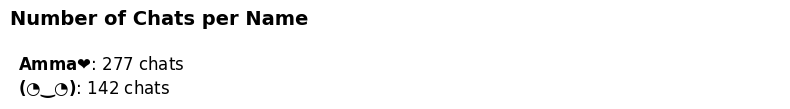

In [166]:
import matplotlib.pyplot as plt

def plot_chatcount(df_data):
    # Count chats per name
    chat_counts = df_data['Name'].value_counts()

    # Set up the figure height dynamically based on number of entries
    fig_height = max(1, len(chat_counts) * 0.6)
    plt.figure(figsize=(8, fig_height))
    plt.axis('off')  # Hide axes

    # Write each name and chat count with proper vertical spacing
    for i, (name, count) in enumerate(chat_counts.items()):
        y_pos = len(chat_counts) - i  # descending order (top to bottom)
        plt.text(0.01, y_pos, f"$\\bf{{{name}}}$: {count} chats", fontsize=12, va='top')


    plt.title("Number of Chats per Name", fontsize=14, weight='bold', loc='left')
    plt.xlim(0, 1)
    plt.ylim(0, len(chat_counts) + 1)
    plt.tight_layout()
    plt.show()

plot_chatcount(df_data)

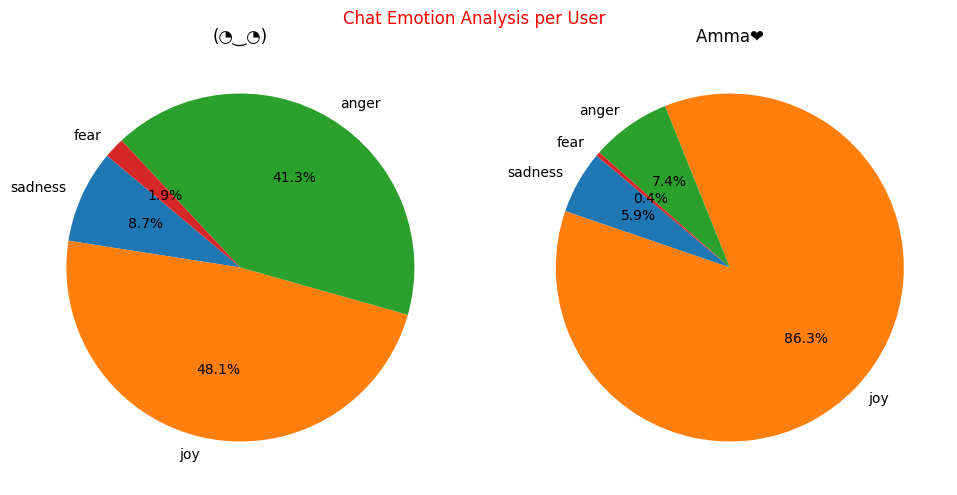

In [169]:

# Label mapping
label_map = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

plot_piechart(chat_emotions, label_map)